# Rede neural 65622 - Transformada em classificador
Melhor desempenho considerando o critério de maior cos_sim e menor loss 

In [1]:
# Importando as bibliotecas necessarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
pd.set_option("display.max_rows", 300)

D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\envs\zika\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning: Passing (type

In [2]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size):
        super(Net, self).__init__()
        self.num_layers = num_layers

        self.linears = nn.ModuleList([nn.Linear(input_size, layers_size[0])])
        for i in range(0, self.num_layers-2):
            self.linears.extend([nn.Linear(layers_size[i], layers_size[i+1])])              
        self.linears.append(nn.Linear(layers_size[-1], output_size))

# Última camada sem função de ativação --> sigmoide ou tanh
# ReLU em intermediárias
    def forward(self, x):
        for layer in self.linears[0:-1]:                   
            x = F.relu(layer(x))
        x = F.softmax(self.linears[-1](x))
        return(x)

# # Aplicando função de ativação na última camada tbm
# ### Tentar mudar pra sigmoide se deixar a normalização de 0,1
#     def forward(self, x):
#         for layer in self.linears:                   
#             x = torch.sigmoid(layer(x))
# #             x = F.relu(layer(x))
#         return(x)

In [3]:
testes = pd.read_csv("D:/TG-Biomed/Regression_model/Loop_Testes_Regressao2.csv")
rede = testes.iloc[np.where(testes["index"]==65622)]
rede

,index,net_param,ncamadas,n_features,features_col,features_name,random_state,data_train,data_train_resample,test_loss,test_cos_sim,net
15622,65622.0,<bound method Module.parameters of Net(\r\n (...,6,18,[ 1 15 41 49 52 58 86 89 94 97 99 1...,"['AgeGroup', 'Analgesic', 'Diabetesmellitus', ...",77,124,280,0.04118,0.873746,net_65622


In [4]:
print(rede.iloc[0,1])

<bound method Module.parameters of Net(
  (linears): ModuleList(
    (0): Linear(in_features=18, out_features=12, bias=True)
    (1): Linear(in_features=12, out_features=9, bias=True)
    (2): Linear(in_features=9, out_features=6, bias=True)
    (3): Linear(in_features=6, out_features=3, bias=True)
    (4): Linear(in_features=3, out_features=1, bias=True)
    (5): Linear(in_features=1, out_features=1, bias=True)
  )
)>


In [5]:
data = pd.read_pickle("D:/TG-Biomed/Data_prep/data_closed_rigid_o")
pf50 = np.round(data["PF50_closed_rigid"].values, 2)

# Divide em classes de acordo com a faixa de valor do PF50
pf50_class = np.zeros(len(pf50))
cont = 0
for i in pf50:
    if i < 0.1: pf50_class[cont]=0
    if i > 0.1 and i <= 0.2: pf50_class[cont]=1
    if i > 0.2 and i <= 0.3: pf50_class[cont]=2
    if i > 0.3: pf50_class[cont]=3
#     print('%.4f == %d' % (i, pf50_class[cont]))
    cont = cont+1

In [6]:
print(pf50_class)

[1. 1. 1. 1. 1. 1. 2. 1. 0. 1. 3. 1. 1. 0. 1. 0. 1. 2. 1. 1. 1. 0. 1. 1.
 1. 3. 1. 1. 0. 2. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 1. 0. 3. 1.
 0. 1. 1. 1. 1. 1. 0. 2. 3. 1. 0. 3. 0. 1. 1. 2. 2. 1. 2. 1. 1. 2. 2. 3.
 2. 0. 1. 1. 1. 0. 3. 2. 3. 1. 1. 1. 1. 1. 2. 2. 1. 1. 2. 1. 1. 2. 1. 1.
 1. 1. 1. 3. 1. 2. 1. 1. 1. 2. 3. 2. 2. 1. 1. 2. 1. 1. 0. 2. 2. 3. 2. 1.
 1. 1. 1. 0. 0. 1. 3. 3. 1. 1. 1. 0. 2. 0. 2. 2. 1. 1. 1. 3. 3. 1. 1. 2.
 2. 1. 1. 1. 1. 1. 2. 1. 3. 1. 1. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 1. 0. 1.
 0. 1. 1. 1. 0. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 1. 0. 3. 0. 1. 1. 1. 2. 2.
 3. 2. 2. 3. 1. 1. 1. 1. 1. 2. 0. 2. 1. 2. 3.]


Numero de features: 18
Colunas:  [0, 15, 41, 49, 52, 58, 86, 89, 94, 97, 99, 111, 117, 123, 135, 152, 167, 173]
Features:  ['Age', 'Analgesic', 'Diabetesmellitus', 'Hblocker', 'Hypercholesterolemia', 'Meglitinide', 'Epilepsy', 'Fatty liver', 'Hiatus hernia', 'Inflammation of the tibial nerve', 'Kidney failure', 'Sickle cell anemia', 'Varicose veins of the legs', 'Depression', 'Vasovagal syncope', 'Hypothyroidism_total', 'Internal fixation in the leg', 'PaceMaker']
Random State: 77


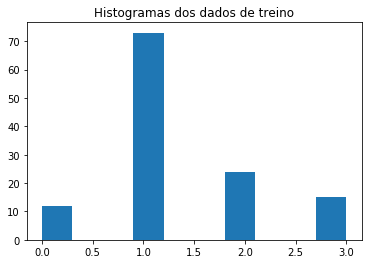

In [7]:
# Sorteando quais caracteristicas usar
n_features = rede.iloc[0,3]
print('Numero de features: %d' % (n_features))
# Troca de AgeGroup(1) por Age(0)
columns =   [0, 15, 41, 49, 52, 58, 86, 89, 94, 97, 99, 111, 117, 123, 135, 152, 167, 173]
print('Colunas: ',columns)

features = data.iloc[:,columns]
features_names = features.columns
print('Features: ',list(features_names))
X = features.values
y = pf50_class.reshape(len(pf50_class), 1)

# Separando o dataset em treino e teste e validação (treino 60, teste 30, validação 10)
random_state = rede.iloc[0,6]
print('Random State: %d' % (random_state))
X_train, X_test_vali, y_train, y_test_vali = train_test_split(X, y, test_size=0.4, random_state=random_state)
X_vali, X_test, y_vali, y_test = train_test_split(X_test_vali, y_test_vali, test_size=0.75, random_state=random_state)

plt.figure()
n, bins, patches = plt.hist(y_train)
plt.title("Histogramas dos dados de treino")
plt.show()

Data train: 124
Data train resample: 292
Histograma dos dados de treino com Resample SMOTE


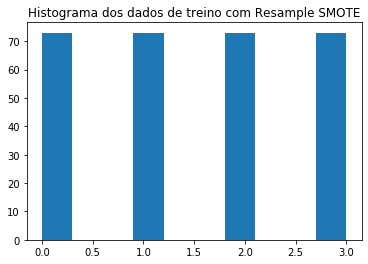

In [8]:
# SMOTE - Data Augmentation
print('Data train: %d' % (X_train.shape[0]))
sm = SMOTE(k_neighbors=3, random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train)
print('Data train resample: %d' % (X_train_res.shape[0]))

# Histograma dos dados de treino resample
print("Histograma dos dados de treino com Resample SMOTE")
n_res, bins_res, patches_res = plt.hist(y_train_res)
plt.title("Histograma dos dados de treino com Resample SMOTE")
plt.show()

In [9]:
# Declarando o dado resample como dado de treino
X_train = X_train_res
y_train = y_train_res.reshape(len(y_train_res), 1)

# Ajustando o escalamento ao dado de TREINAMENTO (fit) e transformando o dado de treinamento
scaler_x = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler_x.fit_transform(X_train)

# Precisa da normalização do y?
# scaler_y = MinMaxScaler(feature_range=(0, 1))
# y_train_scaled = scaler_y.fit_transform(y_train)
y_train_scaled = y_train

# Transformando o dado de validação
X_vali_scaled = scaler_x.fit_transform(X_vali)
# y_vali_scaled = scaler_y.fit_transform(y_vali)
y_vali_scaled = y_vali

torch.manual_seed(1234)

num_layers = rede.iloc[0,2]
print('Number of layers: %d' % (num_layers))
layer_init_size = 20
print('Inicial size layer: %d' % (layer_init_size))
layers_size = np.linspace(layer_init_size, 4, num_layers-1, dtype=int)
print('Layers sizes:', list(layers_size))

net = Net(input_size=X.shape[1], num_layers=num_layers, layers_size=layers_size , output_size=4)


Number of layers: 6
Inicial size layer: 20
Layers sizes: [20, 16, 12, 8, 4]


#### Save best model
https://github.com/pytorch/examples/blob/60108edfa3838a823220e16428cb5f98e8e88d53/imagenet/main.py#L353

In [10]:
def save_checkpoint(state, is_best, filename='model_best.pth.tar'):
    if is_best:
        torch.save(state, filename)
        print('*****Saved epoch: %d *****' % (state['epoch']))

In [11]:
# Choose optmizer and loss function
criterion = nn.CrossEntropyLoss()
# criterion = nn.MultiLabelSoftMarginLoss()    # Testar

optimizer = torch.optim.Adam(net.parameters(), lr = 0.001)
# optimizer = torch.optim.SGD(net.parameters(), lr = 0.05, momentum = 0.9) # lr = learning rate 

# Treinamento utilizando o dado de treino transformado
# Aumento do número de epochs de 5000 para 100000
epochs = 10000
loss_train = np.zeros(epochs)
loss_vali = np.zeros(epochs)
acc_vali = np.zeros(epochs)
best_acc = 0

for epoch in range(epochs):
    
    inputs = torch.autograd.Variable(torch.Tensor(X_train_scaled.astype(np.float32)).float())
    targets = torch.autograd.Variable(torch.Tensor(y_train_scaled).long())
    
    optimizer.zero_grad()
    out = net(inputs)
    loss = criterion(out, targets.squeeze(1))
    loss.backward()
    optimizer.step()

    loss_train[epoch] = loss.item()
    
    # Validação
    if epoch == 0 or (epoch + 1) % 100 == 0:
        inputs_vali = torch.autograd.Variable(torch.Tensor(X_vali_scaled.astype(np.float32)).float())
        targets_vali = torch.autograd.Variable(torch.Tensor(y_vali_scaled).long())
        out_vali = net(inputs_vali)
        loss_v = criterion(out_vali, targets_vali.squeeze(1))

        loss_vali[epoch] = loss_v.item()
        
        # predicted = out.data
        _, predicted = torch.max(out_vali.data, 1) # Usar dessa forma?
        
        # Calcula acurácia
        error_count = y_vali_scaled.size - np.count_nonzero((targets_vali.squeeze() == predicted) .numpy())
        acc_vali[epoch] = 100 * torch.sum(targets_vali.squeeze() == predicted) / y_vali_scaled.size
        
        # remember best acc and save best model
        # is_best = acc_vali[epoch] >= best_acc (?)
        is_best = acc_vali[epoch] > best_acc
        best_acc = max(acc_vali[epoch], best_acc)
        save_checkpoint({
        'epoch': epoch + 1,
        #'arch': args.arch,
        'state_dict': net.state_dict(),
        'best_acc': best_acc,
        'optimizer' : optimizer.state_dict(),
        }, is_best)
        
        print('Epoch %d Loss: %.4f' % (epoch + 1, loss.item()))
        print('   Validation Loss: %.4f' % (loss_v.item()))
        print('   Errors: %d; Accuracy: %d%%' % (error_count, acc_vali[epoch]))


Epoch 1 Loss: 1.3870
   Validation Loss: 1.3901
   Errors: 20; Accuracy: 0%


D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()
..\aten\src\ATen\native\BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


*****Saved epoch: 100 *****
Epoch 100 Loss: 1.3792
   Validation Loss: 1.3958
   Errors: 17; Accuracy: 15%
Epoch 200 Loss: 1.3225
   Validation Loss: 1.4050
   Errors: 17; Accuracy: 15%
Epoch 300 Loss: 1.2746
   Validation Loss: 1.4263
   Errors: 17; Accuracy: 15%
Epoch 400 Loss: 1.2354
   Validation Loss: 1.4323
   Errors: 17; Accuracy: 15%
Epoch 500 Loss: 1.2178
   Validation Loss: 1.4211
   Errors: 17; Accuracy: 15%
*****Saved epoch: 600 *****
Epoch 600 Loss: 1.1964
   Validation Loss: 1.4094
   Errors: 16; Accuracy: 20%
Epoch 700 Loss: 1.1760
   Validation Loss: 1.4222
   Errors: 16; Accuracy: 20%
Epoch 800 Loss: 1.1672
   Validation Loss: 1.4358
   Errors: 16; Accuracy: 20%
Epoch 900 Loss: 1.1613
   Validation Loss: 1.4476
   Errors: 16; Accuracy: 20%
Epoch 1000 Loss: 1.1565
   Validation Loss: 1.4648
   Errors: 16; Accuracy: 20%
Epoch 1100 Loss: 1.1516
   Validation Loss: 1.4789
   Errors: 16; Accuracy: 20%
Epoch 1200 Loss: 1.1423
   Validation Loss: 1.4742
   Errors: 16; Accurac

In [12]:
# Print net weights
print(net.parameters)

for param in net.parameters():
    print(param.data)

<bound method Module.parameters of Net(
  (linears): ModuleList(
    (0): Linear(in_features=18, out_features=20, bias=True)
    (1): Linear(in_features=20, out_features=16, bias=True)
    (2): Linear(in_features=16, out_features=12, bias=True)
    (3): Linear(in_features=12, out_features=8, bias=True)
    (4): Linear(in_features=8, out_features=4, bias=True)
    (5): Linear(in_features=4, out_features=4, bias=True)
  )
)>
tensor([[-7.3900e-01,  2.0036e-01, -1.1321e-01, -6.2866e-02, -2.0822e-01,
          9.4585e-02, -2.1128e-01, -9.9313e-02,  8.1933e-02, -7.9450e-02,
         -9.8296e-02, -8.7433e-02,  1.2957e-01,  1.0066e-01, -1.4520e-01,
         -2.4146e-02,  1.3002e+00,  7.3883e-02],
        [-1.5714e-01,  1.0903e-01,  4.7717e-02, -9.2240e-02, -1.1561e-01,
          6.0982e-02,  2.1992e-01,  1.1311e-01, -2.2760e-02, -1.1441e-02,
          1.3397e-01, -1.6381e-01,  7.8359e-02, -7.8101e-02,  8.5162e-02,
         -8.4080e-02,  1.1655e-02,  7.9592e-02],
        [ 1.0390e+00,  5.0428e-

In [13]:
epoch = np.arange(0, epochs)
loss_vali_clean = loss_vali[np.nonzero(loss_vali)]
epoch_vali = epoch[np.nonzero(loss_vali)]
acc_vali_clean = acc_vali[np.nonzero(acc_vali)]
epoch_vali_acc = epoch[np.nonzero(acc_vali)]

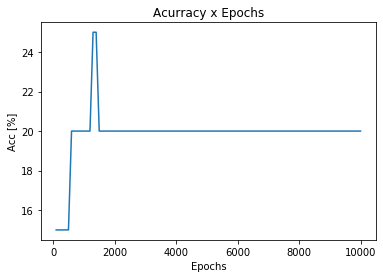

In [14]:
plt.plot(epoch_vali_acc,acc_vali_clean)
plt.title("Acurracy x Epochs")
plt.xlabel("Epochs")
plt.ylabel("Acc [%]")
plt.show()

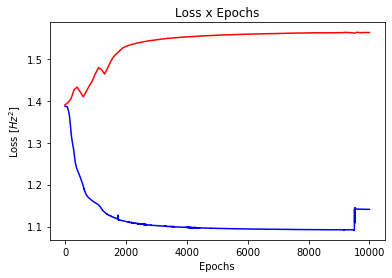

In [15]:
epoch = np.arange(0, epochs)
plt.plot(epoch,loss_train,'b')
plt.plot(epoch_vali,loss_vali_clean, 'r')
plt.title("Loss x Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss [$Hz^2$]")
plt.show()

D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log10
  This is separate from the ipykernel package so we can avoid doing imports until


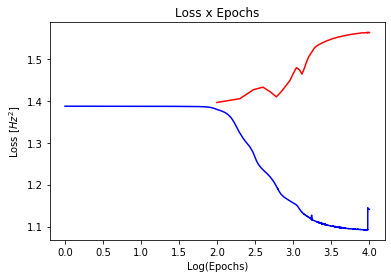

In [16]:
plt.figure()
plt.plot(np.log10(epoch),loss_train,'b')
plt.plot(np.log10(epoch_vali),loss_vali_clean, 'r')
plt.title("Loss x Epochs")
plt.xlabel("Log(Epochs)")
plt.ylabel("Loss [$Hz^2$]")
plt.show()

# Load best model

In [17]:
# to load
checkpoint = torch.load('model_best.pth.tar')
net.load_state_dict(checkpoint['state_dict'])
optimizer.load_state_dict(checkpoint['optimizer'])

## REDE ORIGINAL

LR = 0.05
EPOCHS = 5000

Teste Loss: 0.0412
Teste Cosine Similarity: 0.8737


# Trocar cos_sim para acurácia

D:\anaconda3\envs\zika\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  app.launch_new_instance()


Errors: 46; Accuracy: 26%
Teste Loss: 1.4611


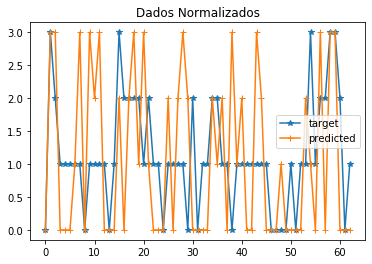

In [18]:
# Transformando o dado de teste
X_test_scaled = scaler_x.fit_transform(X_test)
#y_test_scaled = scaler_y.fit_transform(y_test)
y_test_scaled = y_test

# Avaliando a acurácia do modelo utilizando os dados de teste transformados
inputs = torch.autograd.Variable(torch.Tensor(X_test_scaled.astype(np.float32)).float())
targets = torch.autograd.Variable(torch.Tensor(y_test_scaled).long())

optimizer.zero_grad()
out = net(inputs)
loss = criterion(out, targets.squeeze(1))
loss.backward()
optimizer.step()

#predicted = out.data
_, predicted = torch.max(out.data, 1) # Usar dessa forma?        

error_count = y_test_scaled.size - np.count_nonzero((targets.squeeze() == predicted) .numpy())
acc = 100 * torch.sum(targets.squeeze() == predicted) /  y_test_scaled.size
print('Errors: %d; Accuracy: %d%%' % (error_count, acc))

print('Teste Loss: %.4f' % (loss.item()))

# # Implementando a métrica do Cosine Similarity
# cos = nn.CosineSimilarity(dim=0, eps=1e-6)
# cos_sim = cos(targets, predicted)
# print('Teste Cosine Similarity: %.4f' % (cos_sim.item()))

ninput = np.arange(len(X_test))
plt.figure()
plt.plot(ninput, y_test_scaled, '-*', label = 'target')
plt.plot(ninput, predicted.numpy(), '-+', label = 'predicted')
plt.title('Dados Normalizados')
plt.legend()
plt.show()